# Imports y carga

In [2]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [3]:
# modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
import sklearn as sk
# , precision_recall_curve, roc_curve,
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OneHotEncoder


# configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [4]:
original = pd.read_csv('./Datasets/hotels_procesado.csv')
df_train = original.copy()
df_test = pd.read_csv('./Datasets/hotels_test.csv').copy()

# Procesamiento

### Train

In [5]:
# Eliminamos las columnas que no vamos a usar para entrenar el modelo
df_train.drop(['id', 'arrival_date'], axis='columns', inplace=True)

In [6]:
# convertir 'sin compania' a 0

df_train['company'] = df_train['company'].apply(lambda x: 0 if x == 'Sin compania' else x).astype('float64').astype('int64')
# idem for agent
df_train['agent'] = df_train['agent'].apply(lambda x: 0 if x == 'Sin agente' else x).astype('float64').astype('int64')

In [7]:
df_train.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,0,No Deposit,9,0,0,Transient,115.5,0,1,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,No Deposit,0,0,0,Transient,42.0,1,0,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,0,No Deposit,9,0,0,Transient,229.0,0,2,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,0,Non Refund,154,0,0,Transient,75.0,0,0,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,0,No Deposit,20,0,0,Transient-Party,75.0,0,1,0


### Test

In [8]:
# en el df_test, trato las columnas como el df_train
df_test.drop(['reservation_status_date'], axis='columns', inplace=True)


In [9]:
# children to int
df_test['children'] = df_test['children'].astype('int64')


In [10]:
# convertir nulos a 0
df_test['company'] = df_test['company'].fillna(0).astype('int64')
df_test['agent'] = df_test['agent'].fillna(0).astype('int64')
df_test['country'] = df_test['country'].fillna('Desconocido')


In [11]:
df_test.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id
0,City Hotel,277,2016,November,46,7,1,2,2,0,...,0,Non Refund,0,0,0,Transient,100.0,0,0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e
1,City Hotel,286,2016,May,20,11,0,4,2,0,...,0,No Deposit,30,0,176,Transient-Party,101.0,0,0,aba9aac2-4495-4645-a60e-90328713c999
2,City Hotel,0,2016,August,35,23,0,1,3,0,...,0,No Deposit,0,0,0,Transient,225.0,0,2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad
3,Resort Hotel,196,2016,October,44,29,2,5,2,2,...,0,No Deposit,240,0,0,Transient,96.0,0,0,ce1b400e-afa1-4946-bdff-004b859eb61c
4,Resort Hotel,232,2016,November,48,26,2,1,2,0,...,0,Non Refund,11,0,0,Transient,30.0,0,0,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214


# One hot encoding

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [13]:
train_one_hot = encoder.fit_transform(df_train[['country', 'agent', 'company', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']])

train_columns = encoder.get_feature_names_out(['country', 'agent', 'company', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'])

train_encoded = pd.DataFrame(train_one_hot.toarray(), columns=train_columns)

In [14]:
train_encoded.shape

(53132, 828)

In [15]:
train_ = pd.concat([df_train, train_encoded], axis=1)

In [16]:
train_.drop(['country', 'agent', 'company', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis='columns', inplace=True)

In [17]:
train_.shape

(53132, 843)

In [18]:
test_one_hot = encoder.fit_transform(df_test[['country', 'agent', 'company', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                                      'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']])

test_columns = encoder.get_feature_names_out(['country', 'agent', 'company', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                                              'deposit_type', 'customer_type', 'meal', 'hotel', 'arrival_date_month', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'])

test_encoded = pd.DataFrame(test_one_hot.toarray(), columns=test_columns)


In [19]:
test_encoded.shape

(26535, 764)

# Split dataset

In [20]:
#Creo un dataset con los features que voy a usar para clasificar
x = train_.drop(['is_canceled'], axis='columns', inplace=False)
#Creo un dataset con la variable target
y = train_['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=RANDOM_STATE) #semilla

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 42505
# Datos Prueba: 10627
% Positivos Entrenamiento: 50.745
% Positivos Prueba: 51.341


# Random Search - Cross Validation

In [ ]:
#Cantidad de combinaciones que quiero porbar

n=10

#Conjunto de parámetros que quiero usar
# params_grid = {'criterion':['gini','entropy'],
#                'max_depth': [None],
#                'min_samples_split': list(range(2,30)),
#                'min_samples_leaf':list(range(1,10)),
#                'max_features': list(range(1,10)),
#                'ccp_alpha':np.linspace(0,0.005,n), 
#                }

params_grid = {
    'max_depth': [None],
    'max_features': [0.7],
    'min_samples_split': [25],
    'min_samples_leaf': [1]
}
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
# Mejores hiperparametros del arbol
print(randomcv.best_params_)
# Mejor métrica
print(randomcv.best_score_)

# Grid search - Cross validation

In [21]:
# Construct Grid Parameters
from sklearn.model_selection import GridSearchCV

folds = 5

# Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

""" params_grid = {'criterion':['gini','entropy'],
               'max_depth': [None],
               'min_samples_split': list(range(2,30)),
               'min_samples_leaf':list(range(1,10)),
               'max_features': list(range(1,10)),
               'ccp_alpha':np.linspace(0,0.005,10),
               } """

# 84%
params_grid = {
    'max_depth': [None],
    'max_features': [0.7],
    'min_samples_split': [25],
    'min_samples_leaf': [1],
    'ccp_alpha': [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
}

# %83,7
# params_grid = {
#     'max_depth': [None],
#     'max_features': [0.7],
#     'min_samples_split': [25],
#     'min_samples_leaf': [1]
# }

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

# Clasificador
base_tree = DecisionTreeClassifier()

# Perform Grid Search
gs = GridSearchCV(base_tree, params_grid,
                  cv=kfoldcv,
                  scoring=scorer_fn)

gs.fit(x_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0005, 0.001, 0.0015, 0.002, 0.0025,
                                       0.003],
                         'max_depth': [None], 'max_features': [0.7],
                         'min_samples_leaf': [1], 'min_samples_split': [25]},
             scoring=make_scorer(f1_score))

In [22]:
# Mejores hiperparametros del arbol
print(gs.best_params_)
# Mejor métrica
print(gs.best_score_)

{'ccp_alpha': 0.0005, 'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 25}
0.8355446173734415


In [ ]:
#Atributos considerados y su importancia
best_tree = gs.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

# Decision Tree

In [23]:
# Creo el clasificador
arbol = tree.DecisionTreeClassifier(
    random_state=RANDOM_STATE).set_params(**gs.best_params_)

# Entreno el modelo sin la columnna id

modelo = arbol.fit(X=x_train, y=y_train)

In [ ]:
sorted(list(zip(x.columns.to_list(),
       modelo.feature_importances_)), key=lambda x: -x[1]).head(10)

In [24]:
# Realizamos una predicción sobre el set de test
y_pred = modelo.predict(x_test)

In [25]:
# Scoring
print(f'Best Training Accuracy: {modelo.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo.score(x_test, y_test)}')
print(
    f'Cross-val-score: {cross_val_score(gs.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8399952946712151
Best Testing Accuracy: 0.8412534111226122
Cross-val-score: 0.8343558186480848


Text(50.722222222222214, 0.5, 'True')

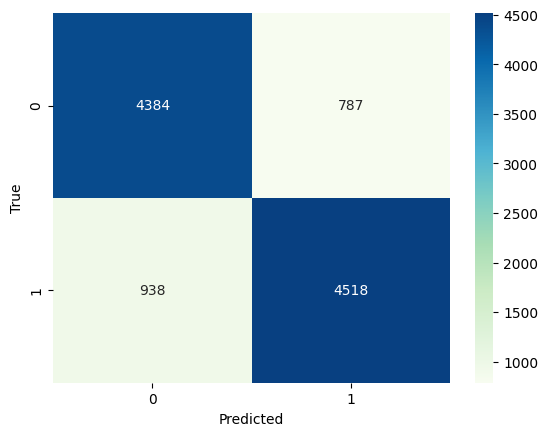

In [103]:
# Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred)

# Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [114]:
# Calculo las métricas en el conjunto de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8376776136256705
Recall: 0.8280791788856305
Precision: 0.8516493873704053
f1 score: 0.8396989127404518


In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      5171
           1       0.85      0.83      0.84      5456

    accuracy                           0.84     10627
   macro avg       0.84      0.84      0.84     10627
weighted avg       0.84      0.84      0.84     10627



# Visualizacion del arbol

In [ ]:
modelo.classes_

In [ ]:
plt.figure(figsize=(12, 12))

tree_plot = tree.plot_tree(modelo,
                           max_depth=2,
                           feature_names=x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])

plt.show(tree_plot)

# Submission

In [ ]:
X_submission = df_test.select_dtypes(exclude=['object'])
y_pred_test = modelo.predict(X_submission)


In [ ]:
df_submission = pd.DataFrame({'id': df_test['id'], 'is_canceled': y_pred_test})
df_submission.head()


In [ ]:
df_submission.to_csv('submission04.csv', index=False)
